# ps1010 mnist 영상인식

## 개요

- BK0287-0101
- MNIST 실습은 0부터 9까지의 숫자를 인식하는 실습이다.
- 각 샘플은 28x28 픽셀을 가지고 있다.
- 파이토치는 Dataset 모듈에서 MNIST 데이터셋을 읽어온다.
- 이 실습에서는 파이토치를 이용해서 다중 클래스 분류 모형을 훈련시키고 훈련된 모델이 테스트 샘플에서 얼마나 잘 작동하는지를 테스트

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## 모델 정의

- 이 모델은 합성곱 계층, 드롭아웃계층, 선형/완전 연결 계층으로 구성
- 모든 계층은 torch.nn 모듈을 통해서 사용
-  __init__ 함수는 모델의 중추 아키텍처, 즉 각 계층의 뉴런 개수와 함께 모든 계층을 정의
- forward 함수는 신경망에서 정보를 앞으로 전달 따라서 이 함수는 각 계층에서 쓸 수 있는 모든 활성화 함수와 계층 뒤에 올 폴링이나 드롭아웃 계층 포함
- forward 함수는 마지막 계층의 출력, 즉 모델의 예측을 반환하며, 이 출력은 타깃 출력(정답)과 동일한 차원을 가짐

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) # 입력 1채널(흑백이미지라서), 출력 16채널, 커널크기 3(일반적으로 홀수), 스트라이드 1
        self.cn2 = nn.Conv2d(16, 32, 3, 1) #출력 채널수를 32로 한것은 더 많은 특징 추출을 위해서
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924133
epoch: 1 [640/60000 (1%)]	 training loss: 1.313336
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678430
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477235
epoch: 1 [2240/60000 (4%)]	 training loss: 0.526729
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469570
epoch: 1 [2880/60000 (5%)]	 training loss: 0.243354
epoch: 1 [3200/60000 (5%)]	 training loss: 0.535540
epoch: 1 [3520/60000 (6%)]	 training loss: 0.250727
epoch: 1 [3840/60000 (6%)]	 training loss: 0.449397
epoch: 1 [4160/60000 (7%)]	 training loss: 0.415974
epoch: 1 [4480/60000 (7%)]	 training loss: 0.327603
epoch: 1 [4800/60000 (8%)]	 training loss: 0.501861
epoch: 1 [5120/60000 (9%)]	 training loss: 0.146283
epoch: 1 [5440/60000 (9%)]	 training loss: 0.372229
epoch: 1 [5760/60000 (10%)]	 training loss: 0.093487
epoch: 1 [6080/60

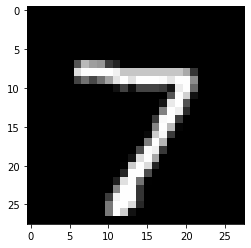

Model prediction is : 7
Ground truth is : 7


In [4]:
  
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))
            
            
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))
    
    
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('psdata/ps1010', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('psdata/ps1010', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)


for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")


# ps1015 MNIST 다른 샘플

- 링크 : https://gaussian37.github.io/dl-pytorch-conv2d/

In [10]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn 
import torch.nn.functional as F

batch_size = 1
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="psdata/ps1015",  # 현재 경로에 datasets/MNIST/ 를 생성 후 데이터를 저장한다.
        train=True,  # train 용도의 data 셋을 저장한다.
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),  # tensor 타입으로 데이터 변경
            # data를 normalize 하기 위한 mean과 std 입력
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
    ),
    batch_size=batch_size,
    shuffle=True
)


In [9]:
# data set의 shape를 확인한다
image, label = next(iter(train_loader))
print(image.shape, label.shape)


torch.Size([1, 1, 28, 28]) torch.Size([1])


In [16]:
# conv2d 사용테스트
nn.Conv2d(
    in_channels= 1,
    out_channels= 3,
    kernel_size = 5,
    stride = 1
)

Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))

In [17]:
# 위의 conv2d를 이용하여 layer를 생성한다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1).to(device)
print(layer)

Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))


In [18]:
# layer의 weight 확인
print(layer.weight)

print(layer.weight.shape)
# 결과의 3,1,5,5는 batch_size, channels, height, width의 크기를 가짐

Parameter containing:
tensor([[[[-0.0410,  0.0524, -0.0451, -0.1452,  0.1425],
          [ 0.1289,  0.0498, -0.0810, -0.1295,  0.0828],
          [-0.0299,  0.1864,  0.0017,  0.1545, -0.1141],
          [ 0.1186,  0.0774,  0.0989, -0.1613,  0.1759],
          [ 0.0505,  0.0448, -0.1707, -0.1054,  0.0503]]],


        [[[ 0.0966, -0.0924,  0.1285, -0.1245,  0.0437],
          [ 0.0249,  0.0396,  0.0139,  0.1116, -0.1172],
          [ 0.1209,  0.0552,  0.0991,  0.0571, -0.1287],
          [ 0.0951, -0.1193, -0.0153, -0.1852,  0.1637],
          [ 0.0478,  0.1413, -0.1903,  0.1355,  0.0565]]],


        [[[ 0.1703,  0.1487,  0.1113,  0.0168, -0.0505],
          [ 0.1785,  0.1056, -0.0446, -0.1551,  0.1421],
          [-0.1537,  0.1825, -0.1644, -0.1315,  0.1501],
          [-0.1954, -0.1090,  0.0033,  0.0997,  0.1922],
          [ 0.1370,  0.0153,  0.1793,  0.0354,  0.0948]]]], requires_grad=True)
torch.Size([3, 1, 5, 5])
